# Assignment 7 - Graph drawing and network analysis

In this assignment you will get to work with graphs using the [graph-tool python module](https://graph-tool.skewed.de/).

Learning goals are:

* perform basic network analysis to create derived graph properties,
* visualize graphs and their properties.

If you require an introduction to basic graph notions, consider to read the so-titled section in [Maël Fabien
's blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5) on this subject. While graph theory and algorithms can lead to fairly deep mathematical discussion, the basic definitions and much practical use of graph data is quite easy to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and maybe the [tutorial notebook](https://stevenbergner.github.io/Teaching/cmpt767/graph-tool-tutorial-todo.ipynb) ([filled version](graph-tool-tutorial.ipynb)). See the [lab setup](#Environment-setup-details) on how you can use graph tool on the lab machines.

In [ ]:
# This assignment was done on Google Colab.
# Installing Grap-tool module on the machine.
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo

In [1]:
# Import Statements
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

# The code of gt_utils is intialized in the below cell
# import gt_utils as au

graph-tool version: 2.44


/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1501: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from 'gi' (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
"""Utilities for Assignment 6 - graph tool and linear algebra
"""
# written by Steven Bergner, 2021

import numpy as np
from numpy import linalg as LA
from scipy.spatial.transform import Rotation as R

import graph_tool.all as gt
assert f"{gt.__version__}" >= "2.37"

def v_id(name, g, v_name):
    """Return integer index of verted with given `name`
    Args:
        name - name of vertex (str)
        g - graph tool graph
        v_name - vertex property array giving names for each vertex
                 as returned when calling g.add_edge_list with hashed=True
    """
    # obtain vertex object
    v = gt.find_vertex(g, v_name, name)[0]
    # get int index
    return g.vertex_index[v]

def edge_vector(name_from, name_to, pos, v_name):
    """Determine 2d-vector between positions of two named nodes
    Args:
        name_from, name_to - names of vertices
        pos - positional vertex property as computed by graph tool layout algorithm
        v_name - vertex property array giving names for each vertex
                 as returned when calling g.add_edge_list with hashed=True
    Returns:
        2-dimensional vector of positional difference between the two nodes
    """
    g = pos.get_graph()
    evec = (pos[v_id(name_to, g, v_name)].a -
            pos[v_id(name_from, g, v_name)].a)
    return evec

def rot2d_rad(angle):
    """Make a 2D rotation matrix for `angle` given in radians. """
    return (R.from_rotvec(angle * np.array([0, 0, 1])) # rotate around out-of-plane z-axis
             .as_matrix()[:2,:2])                      # use top left 2x2 sub matrix

def rot2d_deg(angle):
    """Make a 2D rotation matrix for `angle` given in degrees. """
    return rot2d_rad(angle*np.pi/180)

def rot2d_vec(v, v_as_x=True):
    """Make a 2D rotation matrix that rotates a canonical axis to align with vector `v`
       To align `v` with canonical axis, instead, use the inverse mat.I of the returned matrix mat.
    Args:
        v - vector to rotate to
        v_as_x - if True, rotate the x-axis (default), otherwise rotate y-axis to align with v
    Returns:
        numpy rotation matrix
    """
    v /= LA.norm(v)
    if v_as_x:
        mat = np.matrix([v, v[::-1]])
        mat[0,1] *= -1
    else:
        mat = np.matrix([v[::-1], v])
        mat[1,0] *= -1
    #assert abs(LA.det(mat)-1)<1e-4, "Rotation matrix should have unit determinant"
    return mat

def rotate_vertex_pos(pos, r):
    """Apply rotation matrix `r` to vertex positions `pos` in place."""
    pos.set_2d_array(np.dot(r, pos.get_2d_array(pos=[0,1])))

def rotate_layout(pos, name_from, name_to, v_name, align_x=True):
    """Rotate vertex positions `pos` such that two vertex nodes align with each other on x (or y) axis.
       The operation modifyies `pos` in-place.
    Args:
        pos - positional vertex property as computed by graph tool layout algorithm
        name_from, name_to - names of the two nodes to align along an axis
        v_name - vertex property array giving names for each vertex
                 as returned when calling g.add_edge_list with hashed=True
        align_x - if True, rotate vertices into x-axis (default), otherwise rotate into y-axis
    """
    r = rot2d_vec(edge_vector(name_from, name_to,
                              pos, v_name),
                  v_as_x=align_x).I
    rotate_vertex_pos(pos, r)

# Problem 1: Power grid analysis

In [3]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

 In this graph an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

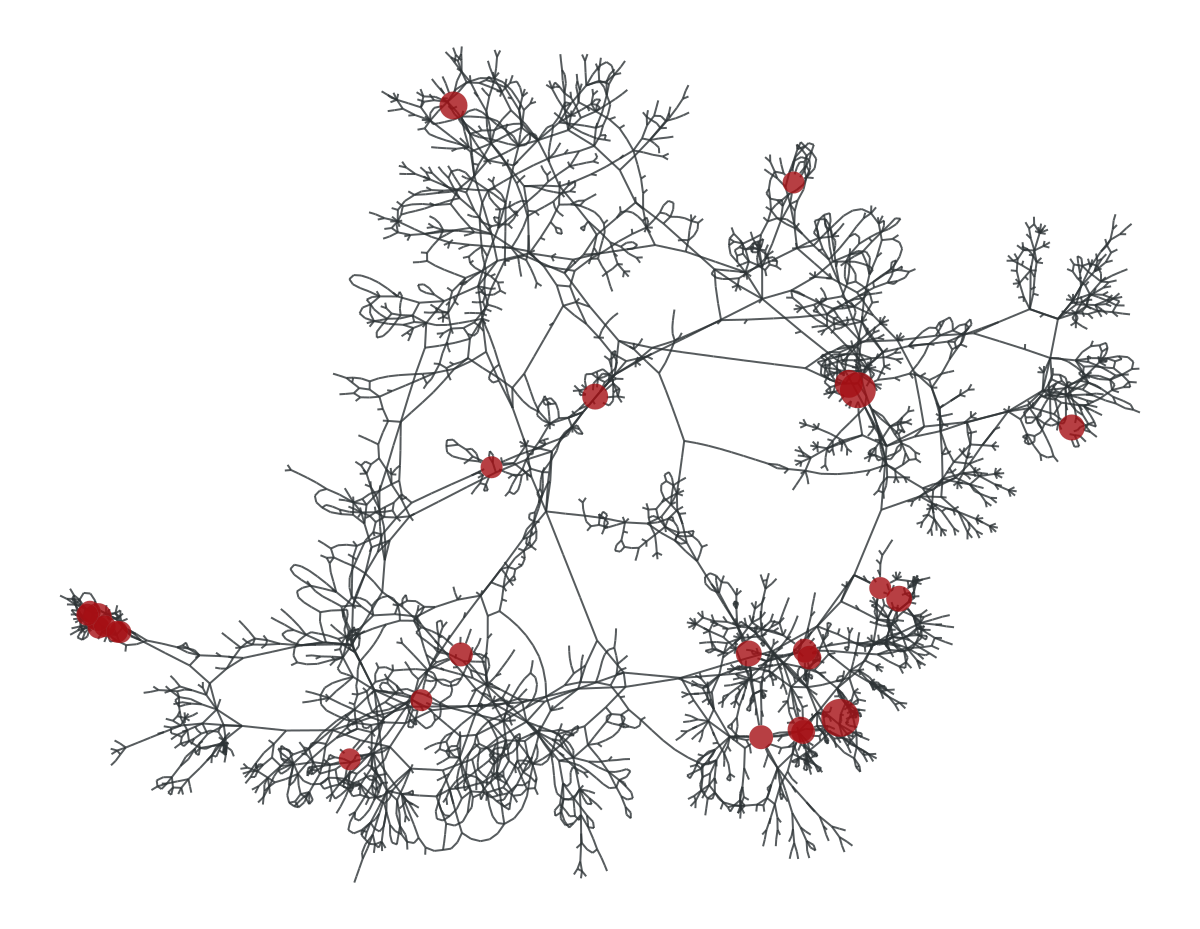

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1220013d90, at 0x7f11e8cfa410>

In [4]:
# Creating a new vertex property
big_vprop = g.new_vertex_property("int")

# Iterating all the vertices and filtering nodes with more than 10 incident power supply
for v in g.iter_vertices():
  count = g.vertex(v).out_degree()
  if count > 10:
    big_vprop[v] = count
  else:
    big_vprop[v] = 0

# Drawing the graph
gt.graph_draw(g, vertex_size=big_vprop, edge_pen_width=1)

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

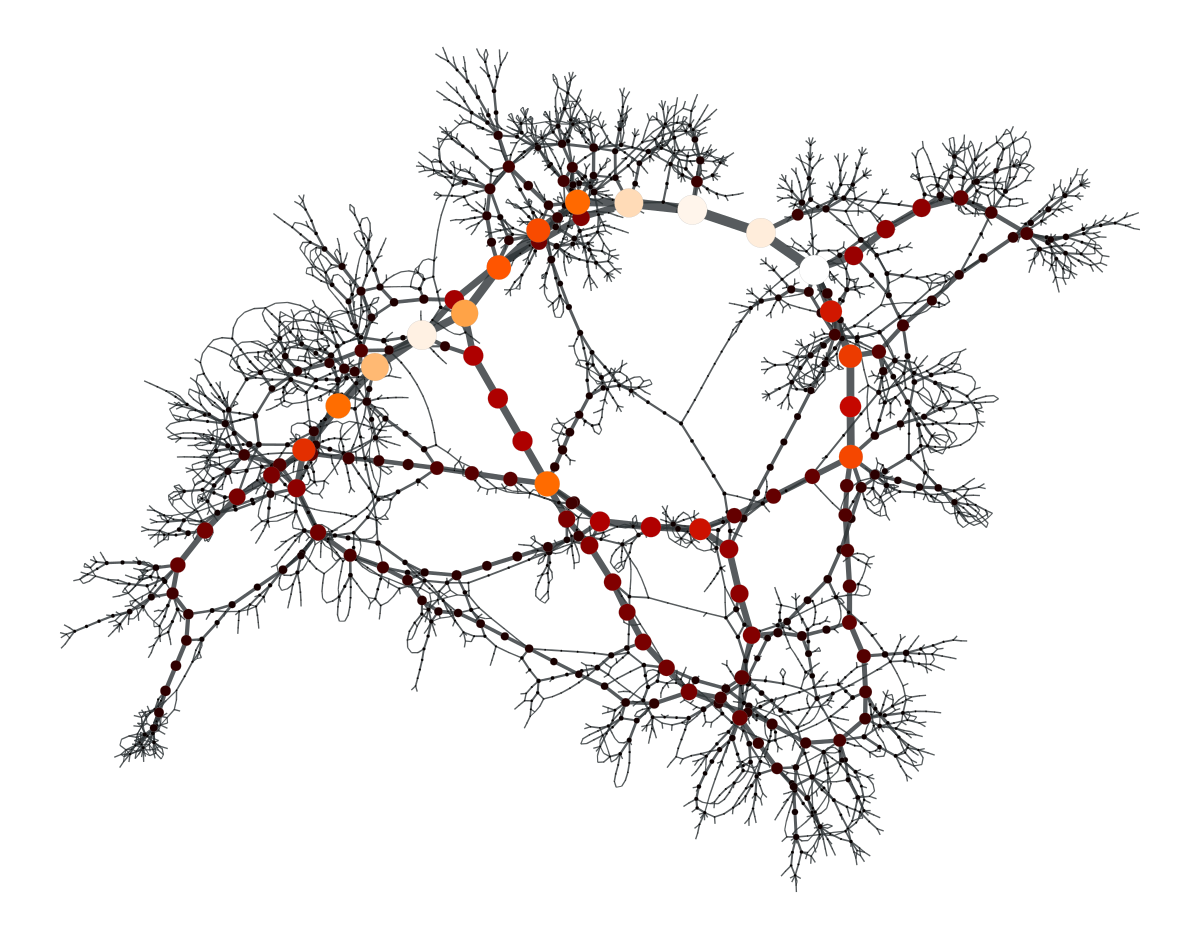

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1220013d90, at 0x7f11e8cf3490>

In [5]:
# Centrality Measure to indicate powerlines between different parts of network.
ver_prop, edg_prop = gt.betweenness(g)

gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color=ver_prop,
              vertex_size=gt.prop_to_size(ver_prop, mi=0, ma=15),
              edge_pen_width=gt.prop_to_size(edg_prop, mi=0.5, ma=5),
              vcmap=mpl.cm.gist_heat, vorder=ver_prop)

# Problem 2: Small social graph visualization

In [6]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph that represents the personal network above, remove parallel edges, and draw using a layout that resembles the tidy example given in the [lecture](../index.html) and as shown further below.

In [7]:
g = gt.Graph(directed=False)
v_name = g.add_edge_list(((n,k) for n in X_knows for k in X_knows[n]),
                         hashed=True)
pos = gt.arf_layout(g)
# pos = gt.random_layout(g)
rotate_layout(pos, "Alan", "Mary", v_name)

g.vp['name'] = v_name

# Removing Parallel edges
gt.remove_parallel_edges(g)

In [8]:
vertex_prop = dict(
    fill_color="#FFFFE0",
    text=v_name,
    size=10
)

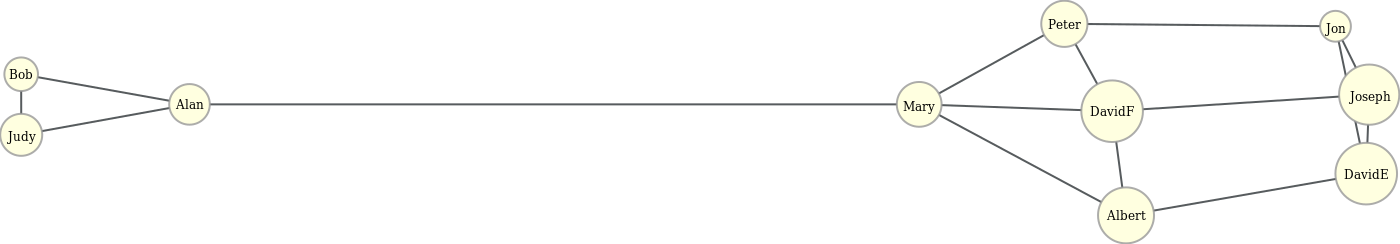

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f11e8ce72d0, at 0x7f11e8d00790>

In [9]:
gt.graph_draw(
    g,
    pos=pos,
    vprops=vertex_prop,
    output_size=(700, 700), # adjust to fit screen
    fit_view=1)

# Problem 3: Facebook graph analysis

For this question we will work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. it contains the ego nodes, the friends of each of these facebook users, and the connections among those friends.

Goal below is to determine influencers among the users, based on a measure of centrality and not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [24]:
# Mounting google drive to import the facebook data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path_prefix = "/content/gdrive/MyDrive/bd2/data"

import sys
sys.path.insert(1, path_prefix)

Mounted at /content/gdrive


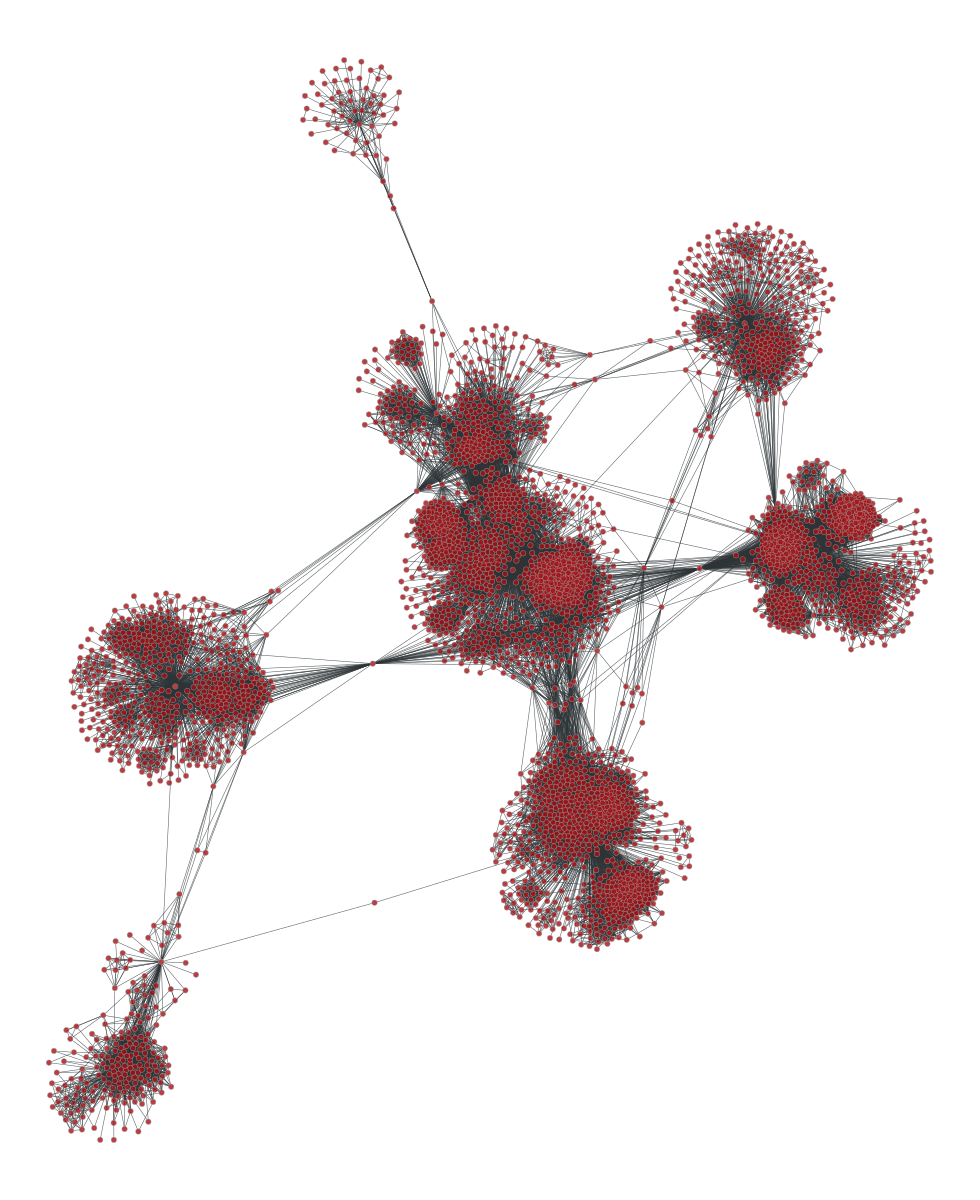

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f11e45d8bd0, at 0x7f11ee81e290>

In [16]:
graph_dir = '/content/gdrive/MyDrive/bd2/data/facebook_combined.txt'

# Local System Path
# The graph file must be in the path where the notebook is present.
#graph_dir ='facebook_combined.txt.gz'

# Loading the graph from the file
g = gt.load_graph_from_csv(graph_dir, csv_options={'delimiter': ' '})
gt.graph_draw(g)

**Task 3b:** Calculate and show a histogram of pairwise distances among users. Internally, this distance would be computed for the shortest path of connections among any pair of users.

Use a log-scale of the frequencies to scale the histogram bars.

What is the diameter of this graph?

*Hint:* Calculating and drawing the histograms amounts to two lines of code using `gt` and `plt` modules.

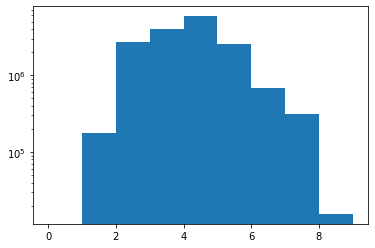

In [17]:
# Calculating the pairwise distances among users
cnt, bins = gt.distance_histogram(g)

# plotting the histogram
plt.hist(bins[:-1], weights=cnt, bins=bins, log=True)
plt.show()

The diameter of the graph is 8

**Task 3c:** Determine influencers, i.e. people within the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a drawing of a GraphView that only retains nodes with a `pagerank` $< 0.002$.

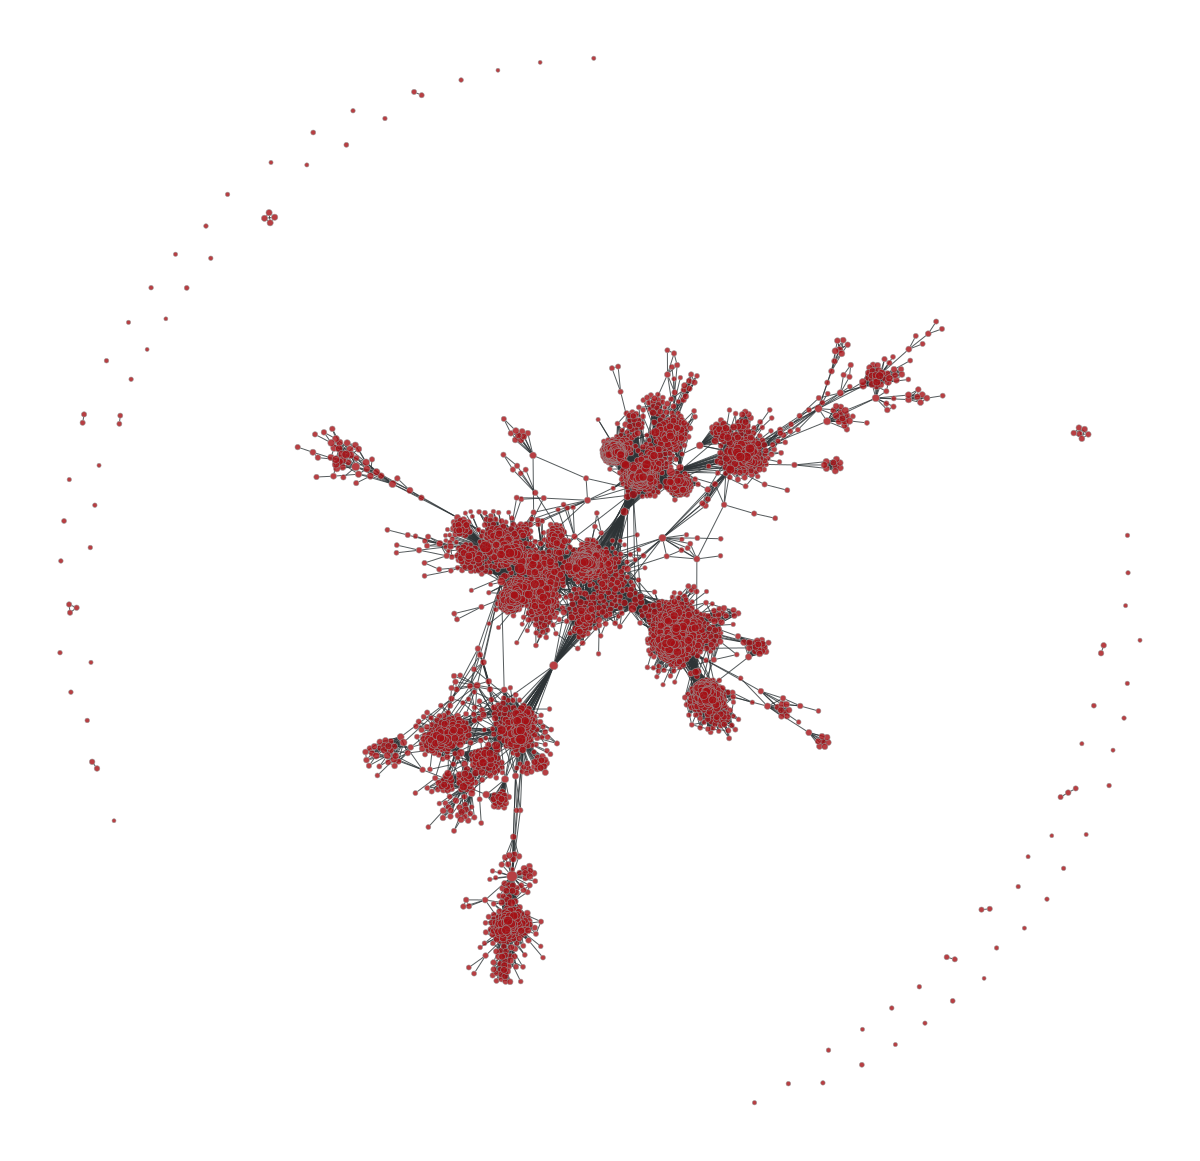

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f11e44c59d0, at 0x7f11e4575d50>

In [18]:
# Calculating the pagerank values
page_rank_values = gt.pagerank(g)

# Assigning it as vertex property
g.vp['pr'] = page_rank_values

g = gt.GraphView(g, vfilt=g.vertex_properties['pr'].a < 0.002)

# Drawing the graph
gt.graph_draw(g, vertex_size=gt.prop_to_size(page_rank_values, mi=2, ma=10),
              vorder=page_rank_values, vcmap=mpl.cm.gist_heat, edge_pen_width=0.5)

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

In [19]:
large_vertex = gt.label_largest_component(g)
g = gt.GraphView(g, vfilt=large_vertex)
# gt.graph_draw(g)

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that play central roles among their friends.

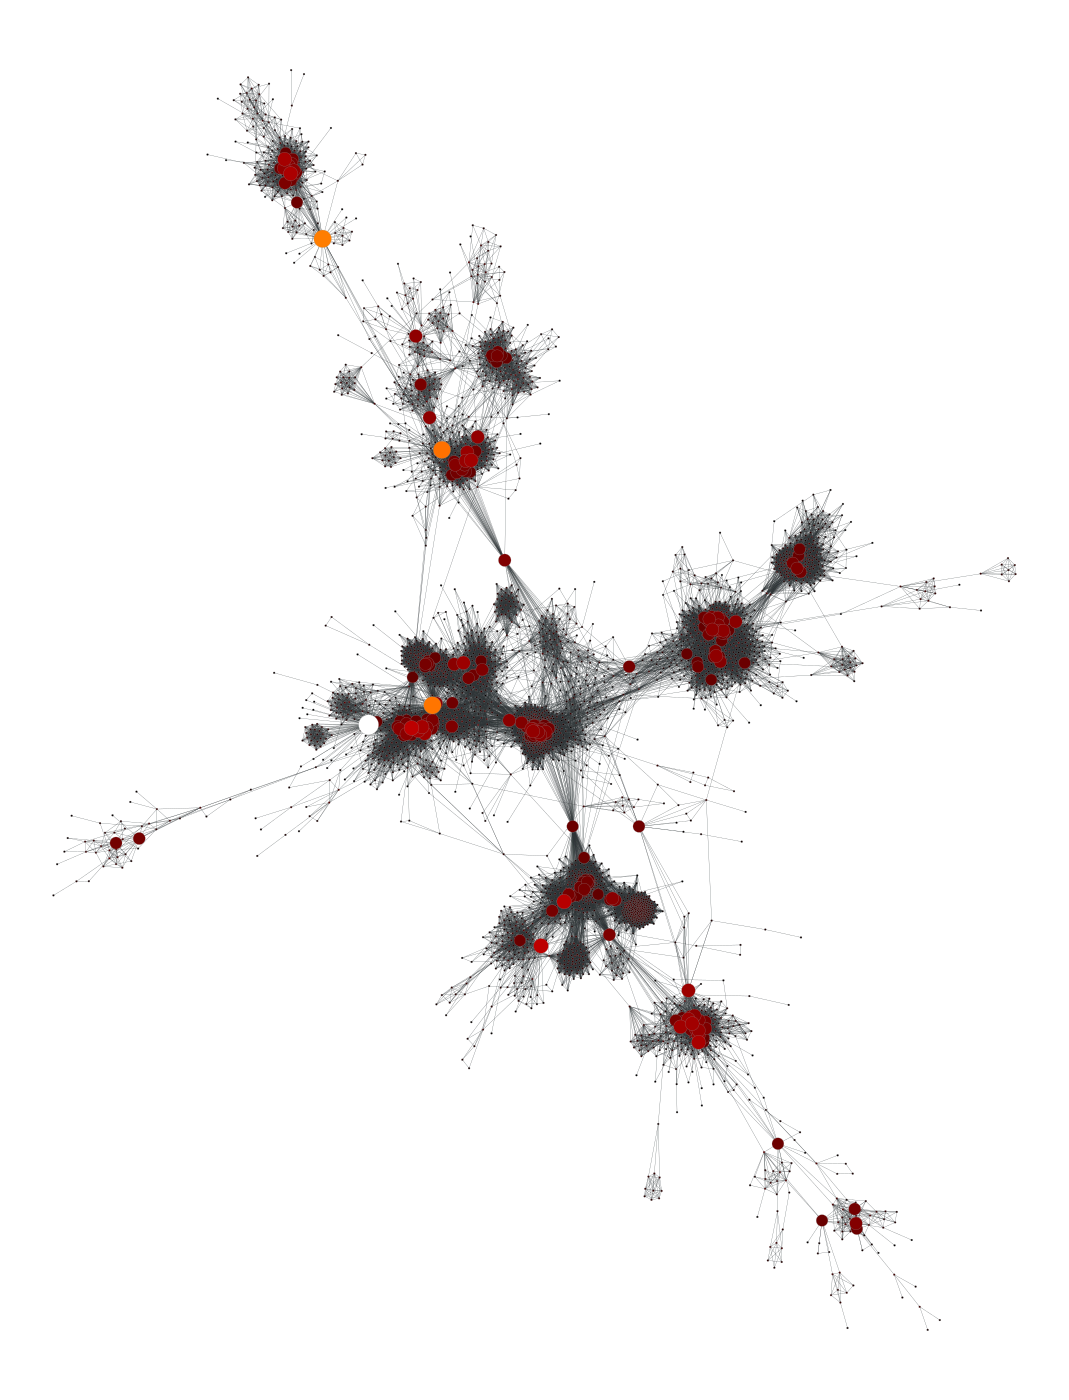

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f11e44c5790, at 0x7f11e44ca290>

In [20]:
# recalculating page rank values
pr_values = gt.pagerank(g)

pr_vprop = g.new_vertex_property('float')
for v in g.vertices():
    if pr_values[v] > 0.0005:
        pr_vprop[v] = pr_values[v]

gt.graph_draw(g, output_size=(700, 700), vcmap=mpl.cm.gist_heat, 
              vertex_size=gt.prop_to_size(pr_vprop, mi=1, ma=10), vorder=pr_values,
              vertex_fill_color=pr_values)

# Environment setup details

[Setup instruction](https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions#installation-via-package-managers) are available for most environments. To use the setup in the lab, see below.

We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/pybd
```

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
conda init bash
conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

# Submission instructions
Please submit [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A7/A7.ipynb) 
to [CourSys](https://coursys.sfu.ca/2022sp-cmpt-733-g1/+a7/),
filled out with figures included.